In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from utils_v import compute_target_score, estimate_target, save_model
from cmath import isinf
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from helper_classes import MatData, KernelizedSupCon, MLP, cauchy, rbf, gaussian_kernel

In [23]:
!pwd

/gpfs3/well/margulies/users/cpy397/contrastive-learning


In [2]:
def standardize_dataset(dataset):
    features = torch.vstack([dataset[i][0] for i in range(len(dataset))])
    targets = torch.vstack([dataset[i][1] for i in range(len(dataset))])
    print(features.shape)
    print(targets.shape)
    
    features_mean = features.mean(dim=0)
    features_std = features.std(dim=0)
    targets_mean = targets.mean(dim=0)
    targets_std = targets.std(dim=0)
    
    features_std[features_std == 0] = 1
    targets_std[targets_std == 0] = 1
    
    standardized_features = (features - features_mean) / features_std
    standardized_targets = (targets - targets_mean) / targets_std
    
    standardized_dataset = TensorDataset(standardized_features, standardized_targets)
    
    return standardized_dataset

In [3]:
class CustomContrastiveLoss(nn.Module): # my custom loss for my mental health
    def __init__(self, margin=1.0):
        super(CustomContrastiveLoss, self).__init__()
        self.margin = margin  # how far apart the dissimilar pairs should be pushed

    def forward(self, features, targets):
        positive_dist = torch.norm(features - targets, p=2, dim=1)

        # Euclidean distances for negative pairs and apply margin
        # For each target, calculate its distance to all other features and targets
        batch_size = features.shape[0]
        repulsion_loss = 0.0
        for i in range(batch_size):
            for j in range(batch_size):
                if i != j:
                    # Distance from target i to features j
                    dist_to_features = torch.norm(targets[i] - features[j], p=2)
                    # Distance from target i to targets j
                    dist_to_targets = torch.norm(targets[i] - targets[j], p=2)
                    # Apply margin and accumulate repulsion loss
                    repulsion_loss += F.relu(self.margin - dist_to_features) + F.relu(self.margin - dist_to_targets)

        # Mean over all pairs for both attraction and repulsion components
        attraction_loss = positive_dist.mean()
        repulsion_loss /= (batch_size * (batch_size - 1) * 2)  # Normalize by number of negative pairs

        # Total loss: minimize attraction while maximizing repulsion
        total_loss = attraction_loss + repulsion_loss

        return total_loss

In [4]:
dataset = MatData("vectorized_matrices_la5c.npy", "hopkins_age.npy")

In [5]:
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size = 0.2, random_state=42) #train_size = 5
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [6]:
# input_dim_feat = 499500 # vectorized mat, diagonal discarded
# input_dim_target = 59
# # the rest is arbitrary
# hidden_dim_feat_1 = 1024
# hidden_dim_feat_2 = 512
# hidden_dim_target_1 = 24
# hidden_dim_target_2 = 8
# output_dim = 2
# num_epochs = 1000

input_dim_feat = 499500 # vectorized mat, diagonal discarded
input_dim_target = 59
# the rest is arbitrary
hidden_dim_feat = 1000
hidden_dim_target = 24
output_dim = 2
num_epochs = 100


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
temperature = 10
base_temperature = 10 # too low values return nan loss
lr = 0.001 # too low values return nan loss
kernel = gaussian_kernel
batch_size = 5 # too low values return nan loss
n_splits = 5

In [9]:
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [10]:
results_cv = []
best_mape = np.inf
best_r2 = -np.inf
best_average_loss = np.inf

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    
    print(f"Starting fold {fold}")
    
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    std_train_subset = standardize_dataset(train_subset)
    std_val_subset = standardize_dataset(val_subset)

    # Now, 'standardized_train_subset' and 'standardized_val_subset' are ready to be used for training and validation
    # Example: Convert them to DataLoader if needed
    train_loader = DataLoader(std_train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(std_val_subset, batch_size=64, shuffle=False)
    
    # Initialize your model, criterion, and optimizer here
    model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim).to(device)
    criterion = CustomContrastiveLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        for batch_num, (features, targets) in enumerate(train_loader):
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            out_feat, out_target = model(features, targets)
            loss = criterion(out_feat, out_target)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        print(f'Fold {fold} | Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')
            
    val_losses = []
    model.eval() 
    with torch.no_grad():
        total_loss = 0
        total_samples = 0
        for features, targets in val_loader:
            features = features.to(device).float()
            targets = targets.to(device)

            out_feat, out_target = model(features, targets)
            loss = criterion(out_feat, out_target)
            val_losses.append(loss.item())
            total_loss += loss.item() * features.size(0)
            total_samples += features.size(0)
        val_losses =np.array(val_losses)
        average_loss = total_loss / total_samples
        if best_average_loss > average_loss:
            best_average_loss = average_loss
            save_model(model, fold, optimizer, f"best_model_hopkins_cv.pt")
    mape_train, mape_val = compute_target_score(model, train_loader, val_loader, device, 'mape')
    r2_train, r2_val = compute_target_score(model, train_loader, val_loader, device, 'r2')
#     if mape_train < best_mae and r2_train > best_r2: # saving the one which has the best train metrics
#         best_mape = mape_train
#         best_r2 = r2_train
#         save_model(model, fold, optimizer, f"best_model_hopkins_cv.pt")
    results_cv.append([fold, mape_train, r2_train, mape_val, r2_val])

    

Starting fold 0
torch.Size([93, 499500])
torch.Size([93, 59])
torch.Size([24, 499500])
torch.Size([24, 59])
Fold 0 | Epoch 0 | Mean Loss 1.4825827479362488
Fold 0 | Epoch 1 | Mean Loss 1.337328314781189
Fold 0 | Epoch 2 | Mean Loss 1.256672203540802
Fold 0 | Epoch 3 | Mean Loss 1.332231044769287
Fold 0 | Epoch 4 | Mean Loss 1.1552929878234863
Fold 0 | Epoch 5 | Mean Loss 1.2705029249191284
Fold 0 | Epoch 6 | Mean Loss 1.2278813123703003
Fold 0 | Epoch 7 | Mean Loss 1.1675033569335938
Fold 0 | Epoch 8 | Mean Loss 1.21854829788208
Fold 0 | Epoch 9 | Mean Loss 1.0855105519294739
Fold 0 | Epoch 10 | Mean Loss 1.1449102759361267
Fold 0 | Epoch 11 | Mean Loss 1.1026806831359863
Fold 0 | Epoch 12 | Mean Loss 1.0730002522468567
Fold 0 | Epoch 13 | Mean Loss 0.9333019852638245
Fold 0 | Epoch 14 | Mean Loss 0.9965769946575165
Fold 0 | Epoch 15 | Mean Loss 0.960633784532547
Fold 0 | Epoch 16 | Mean Loss 0.9562373459339142
Fold 0 | Epoch 17 | Mean Loss 0.9295369386672974
Fold 0 | Epoch 18 | Mean L

Fold 1 | Epoch 63 | Mean Loss 0.6341090202331543
Fold 1 | Epoch 64 | Mean Loss 0.6327820420265198
Fold 1 | Epoch 65 | Mean Loss 0.6037974059581757
Fold 1 | Epoch 66 | Mean Loss 0.6020501554012299
Fold 1 | Epoch 67 | Mean Loss 0.595058023929596
Fold 1 | Epoch 68 | Mean Loss 0.6380346119403839
Fold 1 | Epoch 69 | Mean Loss 0.6262335777282715
Fold 1 | Epoch 70 | Mean Loss 0.5423419922590256
Fold 1 | Epoch 71 | Mean Loss 0.6186633706092834
Fold 1 | Epoch 72 | Mean Loss 0.5708389282226562
Fold 1 | Epoch 73 | Mean Loss 0.5799882113933563
Fold 1 | Epoch 74 | Mean Loss 0.5564121007919312
Fold 1 | Epoch 75 | Mean Loss 0.5704135894775391
Fold 1 | Epoch 76 | Mean Loss 0.5580191314220428
Fold 1 | Epoch 77 | Mean Loss 0.5495609641075134
Fold 1 | Epoch 78 | Mean Loss 0.5331036746501923
Fold 1 | Epoch 79 | Mean Loss 0.5665600001811981
Fold 1 | Epoch 80 | Mean Loss 0.5675654709339142
Fold 1 | Epoch 81 | Mean Loss 0.5629291534423828
Fold 1 | Epoch 82 | Mean Loss 0.5202614963054657
Fold 1 | Epoch 83 | M

Fold 3 | Epoch 25 | Mean Loss 1.0339378118515015
Fold 3 | Epoch 26 | Mean Loss 0.9622008204460144
Fold 3 | Epoch 27 | Mean Loss 0.9686800241470337
Fold 3 | Epoch 28 | Mean Loss 0.9060491025447845
Fold 3 | Epoch 29 | Mean Loss 0.8375467956066132
Fold 3 | Epoch 30 | Mean Loss 0.9658018946647644
Fold 3 | Epoch 31 | Mean Loss 0.8265327215194702
Fold 3 | Epoch 32 | Mean Loss 0.9274781942367554
Fold 3 | Epoch 33 | Mean Loss 0.9230959117412567
Fold 3 | Epoch 34 | Mean Loss 0.9277197122573853
Fold 3 | Epoch 35 | Mean Loss 0.8417080044746399
Fold 3 | Epoch 36 | Mean Loss 0.804212212562561
Fold 3 | Epoch 37 | Mean Loss 0.8313669264316559
Fold 3 | Epoch 38 | Mean Loss 0.8382694721221924
Fold 3 | Epoch 39 | Mean Loss 0.8359838128089905
Fold 3 | Epoch 40 | Mean Loss 0.7431919872760773
Fold 3 | Epoch 41 | Mean Loss 0.8167958557605743
Fold 3 | Epoch 42 | Mean Loss 0.8271759748458862
Fold 3 | Epoch 43 | Mean Loss 0.800975114107132
Fold 3 | Epoch 44 | Mean Loss 0.7241008579730988
Fold 3 | Epoch 45 | Me

Fold 4 | Epoch 90 | Mean Loss 0.5284376740455627
Fold 4 | Epoch 91 | Mean Loss 0.5352140665054321
Fold 4 | Epoch 92 | Mean Loss 0.5524659156799316
Fold 4 | Epoch 93 | Mean Loss 0.5071049928665161
Fold 4 | Epoch 94 | Mean Loss 0.5346395373344421
Fold 4 | Epoch 95 | Mean Loss 0.4921553432941437
Fold 4 | Epoch 96 | Mean Loss 0.4661918878555298
Fold 4 | Epoch 97 | Mean Loss 0.5108111947774887
Fold 4 | Epoch 98 | Mean Loss 0.5113405883312225
Fold 4 | Epoch 99 | Mean Loss 0.5560811161994934
Training target estimator
Training target estimator


In [35]:
# Assuming you have a predefined split or a separate validation dataset
# If not, you should split your train_dataset before standardizing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Compute global mean and std for the entire training dataset
features = torch.vstack([train_dataset[i][0] for i in range(len(train_loader))])
targets = torch.vstack([train_dataset[i][1] for i in range(len(train_loader))])

features_mean, features_std, targets_mean, targets_std = compute_global_stats(train_dataset)

# Apply standardization to the entire dataset
standardized_features = (features - features_mean) / features_std
standardized_targets = (targets - targets_mean) / targets_std

# Create TensorDataset for the standardized dataset
standardized_train_dataset = TensorDataset(standardized_features, standardized_targets)

# Split into training and validation datasets if needed
# train_dataset, val_dataset = torch.utils.data.random_split(standardized_train_dataset, [train_size, val_size])
# Assuming you have a separate validation dataset or have already split the data

train_loader = DataLoader(standardized_train_dataset, batch_size=batch_size, shuffle=True)

# Ensure val_loader is defined, possibly using a separate validation set

# Initialize your model, criterion, and optimizer
model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim).to(device)
criterion = KernelizedSupCon(method='expw', temperature=temperature, base_temperature=base_temperature, kernel=kernel)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    for batch_num, (features, targets) in enumerate(train_loader):
        features, targets = features.to(device), targets.to(device)
        optimizer.zero_grad()
        out_feat, out_target = model(features, targets)
        loss = criterion(out_feat, out_target)
        loss.backward()
        batch_losses.append(loss.item())
        optimizer.step()
    print(f'Epoch {epoch} | Mean Loss {sum(batch_losses)/len(batch_losses)}')

# Validation loop
# val_losses = []
# model.eval() 
# with torch.no_grad():
#     total_loss = 0
#     total_samples = 0
#     for features, targets in val_loader:
#         features = features.to(device).float()
#         targets = targets.to(device)

#         out_feat, out_target = model(features, targets)
#         loss = criterion(out_feat, out_target)
#         val_losses.append(loss.item())
#         total_loss += loss.item() * features.size(0)
#         total_samples += features.size(0)
#     val_losses = np.array(val_losses)
#     average_loss = total_loss / total_samples
#     print('Validation Mean Loss: %6.2f' % (average_loss))

# Compute and print evaluation metrics if necessary
# mape_train, mape_val = compute_target_score(model, train_loader, val_loader, device, 'mape')
# r2_train, r2_val = compute_target_score(model, train_loader, val_loader, device, 'r2')
# results_cv.append(['Overall', mape_train, r2_train, mape_val, r2_val])
# print(results_cv)


Epoch 0 | Mean Loss 1.3616798400878907
Epoch 1 | Mean Loss 1.354862356185913
Epoch 2 | Mean Loss 1.3148438692092896
Epoch 3 | Mean Loss 1.3571008920669556
Epoch 4 | Mean Loss 1.3193791151046752
Epoch 5 | Mean Loss 1.3327240228652955
Epoch 6 | Mean Loss 1.3277281761169433
Epoch 7 | Mean Loss 1.3289444208145142
Epoch 8 | Mean Loss 1.3378843069076538
Epoch 9 | Mean Loss 1.317392683029175
Epoch 10 | Mean Loss 1.3506352663040162
Epoch 11 | Mean Loss 1.3399664878845214
Epoch 12 | Mean Loss 1.323616361618042
Epoch 13 | Mean Loss 1.3325619459152223
Epoch 14 | Mean Loss 1.3311208009719848
Epoch 15 | Mean Loss 1.3405274629592896
Epoch 16 | Mean Loss 1.3558753728866577
Epoch 17 | Mean Loss 1.306177568435669
Epoch 18 | Mean Loss 1.3226912498474122
Epoch 19 | Mean Loss 1.3237359762191772
Epoch 20 | Mean Loss 1.3234088182449342
Epoch 21 | Mean Loss 1.3177572250366212
Epoch 22 | Mean Loss 1.2950052976608277
Epoch 23 | Mean Loss 1.3069126844406127
Epoch 24 | Mean Loss 1.3221591711044312
Epoch 25 | Mea

Epoch 205 | Mean Loss 1.289695715904236
Epoch 206 | Mean Loss 1.2730433940887451
Epoch 207 | Mean Loss 1.2641244411468506
Epoch 208 | Mean Loss 1.2439054489135741
Epoch 209 | Mean Loss 1.2545250177383422
Epoch 210 | Mean Loss 1.242627167701721
Epoch 211 | Mean Loss 1.2575950860977172
Epoch 212 | Mean Loss 1.2542659282684325
Epoch 213 | Mean Loss 1.2726576805114747
Epoch 214 | Mean Loss 1.259055495262146
Epoch 215 | Mean Loss 1.2450913190841675
Epoch 216 | Mean Loss 1.241499388217926
Epoch 217 | Mean Loss 1.2389806985855103
Epoch 218 | Mean Loss 1.2585210800170898
Epoch 219 | Mean Loss 1.263112473487854
Epoch 220 | Mean Loss 1.2921778440475464
Epoch 221 | Mean Loss 1.2624018907546997
Epoch 222 | Mean Loss 1.235888409614563
Epoch 223 | Mean Loss 1.2543436527252196
Epoch 224 | Mean Loss 1.2759108066558837
Epoch 225 | Mean Loss 1.2488525629043579
Epoch 226 | Mean Loss 1.2913944244384765
Epoch 227 | Mean Loss 1.2371384620666503
Epoch 228 | Mean Loss 1.2196063995361328
Epoch 229 | Mean Loss 

Epoch 406 | Mean Loss 1.2602952718734741
Epoch 407 | Mean Loss 1.2499021291732788
Epoch 408 | Mean Loss 1.2796754360198974
Epoch 409 | Mean Loss 1.2254726886749268
Epoch 410 | Mean Loss 1.2535171031951904
Epoch 411 | Mean Loss 1.2895574808120727
Epoch 412 | Mean Loss 1.2739389419555665
Epoch 413 | Mean Loss 1.2879810094833375
Epoch 414 | Mean Loss 1.2194210648536683
Epoch 415 | Mean Loss 1.2210783123970033
Epoch 416 | Mean Loss 1.2848376989364625
Epoch 417 | Mean Loss 1.2577597141265868
Epoch 418 | Mean Loss 1.251668667793274
Epoch 419 | Mean Loss 1.2406530618667602
Epoch 420 | Mean Loss 1.2352956056594848
Epoch 421 | Mean Loss 1.2772870540618897
Epoch 422 | Mean Loss 1.2732063055038452
Epoch 423 | Mean Loss 1.2258206963539124
Epoch 424 | Mean Loss 1.262274479866028
Epoch 425 | Mean Loss 1.2974668860435485
Epoch 426 | Mean Loss 1.2218557715415954
Epoch 427 | Mean Loss 1.2518522977828979
Epoch 428 | Mean Loss 1.2849309682846068
Epoch 429 | Mean Loss 1.252336287498474
Epoch 430 | Mean Lo

Epoch 607 | Mean Loss 1.2485331058502198
Epoch 608 | Mean Loss 1.2234508991241455
Epoch 609 | Mean Loss 1.2510621070861816
Epoch 610 | Mean Loss 1.2642542839050293
Epoch 611 | Mean Loss 1.2663268566131591
Epoch 612 | Mean Loss 1.2992246389389037
Epoch 613 | Mean Loss 1.2398028135299684
Epoch 614 | Mean Loss 1.2767603874206543
Epoch 615 | Mean Loss 1.234957218170166
Epoch 616 | Mean Loss 1.2388031721115111
Epoch 617 | Mean Loss 1.2660581827163697
Epoch 618 | Mean Loss 1.2493893265724183
Epoch 619 | Mean Loss 1.2627076864242555
Epoch 620 | Mean Loss 1.2656526803970336
Epoch 621 | Mean Loss 1.2453335404396058
Epoch 622 | Mean Loss 1.2784750938415528
Epoch 623 | Mean Loss 1.250542116165161
Epoch 624 | Mean Loss 1.2590900897979735
Epoch 625 | Mean Loss 1.2893893003463746
Epoch 626 | Mean Loss 1.2458521962165832
Epoch 627 | Mean Loss 1.2222703695297241
Epoch 628 | Mean Loss 1.2633907794952393
Epoch 629 | Mean Loss 1.2358529329299928
Epoch 630 | Mean Loss 1.2256526470184326
Epoch 631 | Mean L

Epoch 808 | Mean Loss 1.2406450510025024
Epoch 809 | Mean Loss 1.2191683053970337
Epoch 810 | Mean Loss 1.24475257396698
Epoch 811 | Mean Loss 1.2357393026351928
Epoch 812 | Mean Loss 1.224582552909851
Epoch 813 | Mean Loss 1.2397825121879578
Epoch 814 | Mean Loss 1.2519257068634033
Epoch 815 | Mean Loss 1.2754154920578002
Epoch 816 | Mean Loss 1.2453060507774354
Epoch 817 | Mean Loss 1.2873723745346068
Epoch 818 | Mean Loss 1.2583105087280273
Epoch 819 | Mean Loss 1.243376660346985
Epoch 820 | Mean Loss 1.2402193427085877
Epoch 821 | Mean Loss 1.2912909030914306
Epoch 822 | Mean Loss 1.2340953826904297
Epoch 823 | Mean Loss 1.2270352482795714
Epoch 824 | Mean Loss 1.2364802837371827
Epoch 825 | Mean Loss 1.2188760042190552
Epoch 826 | Mean Loss 1.272071075439453
Epoch 827 | Mean Loss 1.2605307817459106
Epoch 828 | Mean Loss 1.2429760694503784
Epoch 829 | Mean Loss 1.2351041793823243
Epoch 830 | Mean Loss 1.2414917588233947
Epoch 831 | Mean Loss 1.292389154434204
Epoch 832 | Mean Loss 

In [49]:
results_df = pd.DataFrame(results_cv, columns=['Fold', 'Train_MAPE', 'Train_R2', 'Val_MAPE', 'Val_R2'])
results_df.to_csv('cv_results_hopkins.csv', index=False)

In [50]:
results_df

,Fold,Train_MAPE,Train_R2,Val_MAPE,Val_R2
0,0,0.739708,0.650901,1.740213,-1.514190
1,1,1.814204,0.685313,2.286090,-0.881625
2,2,1.109953,0.616215,3.290102,-0.354272
3,3,1.385824,0.508040,2.310466,-0.470970
4,4,1.262301,0.524027,1.605523,-0.505183


In [ ]:
# Compute and print evaluation metrics if necessary
mape_train, mape_val = compute_target_score(model, train_loader, val_loader, device, 'mape')
r2_train, r2_val = compute_target_score(model, train_loader, val_loader, device, 'r2')
results_cv.append(['Overall', mape_train, r2_train, mape_val, r2_val])
print(results_cv)

## Testing

In [12]:
standardized_test_dataset = standardize_dataset(test_dataset)
std_test_loader = DataLoader(standardized_test_dataset, batch_size=batch_size, shuffle=False)



torch.Size([30, 499500])
torch.Size([30, 59])


In [13]:
model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, hidden_dim_target, output_dim)
model.load_state_dict(torch.load('best_model_hopkins_cv.pt')["model"])
criterion = CustomContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer.load_state_dict(torch.load('best_model_hopkins_cv.pt')["optimizer"])

In [14]:
torch.load('best_model_hopkins_cv.pt')["cv_fold"]

1

In [15]:
model.to(device)

MLP(
  (feat_mlp): Sequential(
    (0): Linear(in_features=499500, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1000, out_features=2, bias=True)
  )
  (target_mlp): Sequential(
    (0): Linear(in_features=59, out_features=24, bias=True)
    (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=24, out_features=2, bias=True)
  )
)

In [16]:
test_losses = []
model.eval()
emb_features = [] # saving the embedded features for each batch
emb_targets = []
with torch.no_grad():
    total_loss = 0
    total_samples = 0
    for batch_num, (features, targets) in enumerate(std_test_loader):
        features = features.to(device).float()
        targets = targets.to(device)

        out_feat, out_target = model(features, targets)
        emb_features.append(out_feat.cpu())
        emb_targets.append(out_target.cpu())
        loss = criterion(out_feat, out_target)
        test_losses.append(loss.item())
        total_loss += loss.item() * features.size(0)
        total_samples += features.size(0)
        
    test_losses =np.array(test_losses)
    average_loss = total_loss / total_samples
    print('Mean Test Loss: %6.2f' % (average_loss))
    #np.save(f"losses/test_losses_batch{batch_num}.npy", test_losses)

Mean Test Loss:   1.01


In [17]:
emb_features = np.row_stack(emb_features)

In [18]:
emb_targets = np.row_stack(emb_targets)

In [19]:
emb_features = pd.DataFrame(emb_features,columns = ["Dim_1", "Dim_2"])

In [20]:
emb_targets = pd.DataFrame(emb_targets,columns = ["Dim_1", "Dim_2"])

In [21]:
emb_features["sub"] = np.arange(1, len(emb_features) +1)
emb_targets["sub"] = np.arange(1, len(emb_targets) +1)
emb_features["Type"] = 'Features'
emb_targets["Type"] = 'Targets'


/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

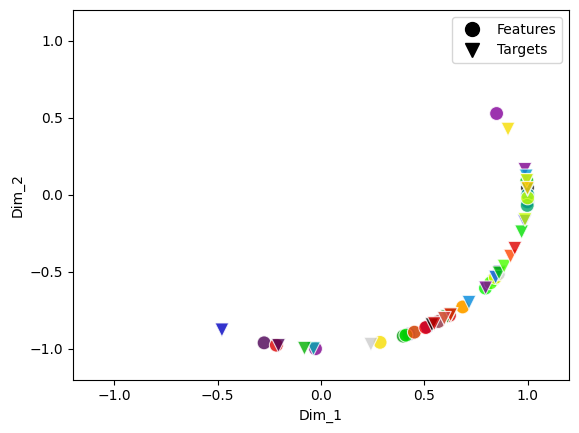

In [22]:
import matplotlib.lines as mlines

sns.scatterplot(emb_features, x = 'Dim_1', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Features')
sns.scatterplot(emb_targets, x = 'Dim_1', marker = 'v', y = 'Dim_2', s = 100, alpha = 0.8, hue = 'sub', palette = 'nipy_spectral', label='Targets')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

feature_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Features')
target_handle = mlines.Line2D([], [], color='black', marker='v', linestyle='None', markersize=10, label='Targets')

plt.legend(handles=[feature_handle, target_handle])


In [41]:
embeddings

,Dim_1,Dim_2,sub,Type
0,0.965320,-0.261070,1,Features
1,-0.710620,-0.703576,2,Features
2,-0.954792,-0.297276,3,Features
3,-0.984910,-0.173069,4,Features
4,-0.943903,-0.330222,5,Features
...,...,...,...,...
112,0.922472,-0.386064,113,Targets
113,-0.851817,0.523839,114,Targets
114,0.986375,-0.164511,115,Targets
115,0.998986,0.045019,116,Targets


In [44]:
embeddings[(embeddings['sub'] == 3) & (embeddings['Type'] == "Features")]

,Dim_1,Dim_2,sub,Type
2,-0.954792,-0.297276,3,Features


In [45]:
embeddings[(embeddings['sub'] == 3) & (embeddings['Type'] == "Targets")]

,Dim_1,Dim_2,sub,Type
2,0.997188,0.074936,3,Targets


In [24]:
mae_train, mae_test = compute_target_score(model, train_loader, test_loader, device, 'mape')
r2_train, r2_test = compute_target_score(model, train_loader, test_loader, device, 'r2')

print(f"Train MAPE: {mae_train}, Test MAPE: {mae_test}.")
print(f"Train R2: {r2_train}, Test R2: {r2_test}.")

Training target estimator
Training target estimator
Train MAPE: 1.5097272396087646, Test MAPE: 1.603095293045044.
Train R2: 6.000279517137663e-07, Test R2: -0.048680421194799206.


## Learning curve

In [25]:
from estimators import TargetEstimator
from utils_v import gather_feats_targets

X_train, y_train = gather_feats_targets(model, train_loader, device)
X_test, y_test = gather_feats_targets(model, test_loader, device)


In [26]:
X = np.row_stack((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [27]:
estimator = TargetEstimator()

In [28]:
train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring = 'r2') #neg_mean_absolute_percentage_error


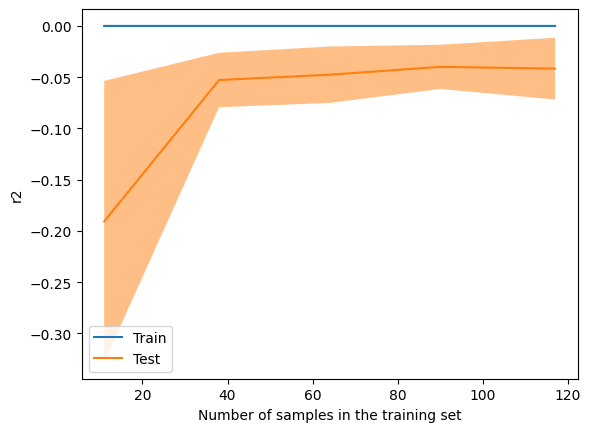

In [29]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="r2")
display.plot()
plt.show()
